In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/patient-survival-prediction/Data Dictionary.csv
/kaggle/input/patient-survival-prediction/Dataset.csv


## Basic Imports

In [2]:
## Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Impute missing values
from sklearn.impute import SimpleImputer, KNNImputer

## Preprocessing
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, RobustScaler

## Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

## Train Test split
from sklearn.model_selection import train_test_split

## Oversampling
from imblearn.over_sampling import SMOTE
from collections import Counter

## Warnings
import warnings
warnings.filterwarnings("ignore")

## Tensorflow imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
df = pd.read_csv("/kaggle/input/patient-survival-prediction/Dataset.csv", usecols=['icu_type','immunosuppression','h1_resprate_max',
                                                  'icu_admit_source', 'ventilated_apache', 'icu_id', 'd1_resprate_max',
                                                  'resprate_apache', 'gcs_unable_apache', 'age','hospital_death'])

df.shape

(91713, 11)

In [4]:
df.head()

,hospital_death,age,icu_admit_source,icu_id,icu_type,gcs_unable_apache,resprate_apache,ventilated_apache,d1_resprate_max,h1_resprate_max,immunosuppression
0,0,68.0,Floor,92,CTICU,0.0,36.0,0.0,34.0,26.0,0.0
1,0,77.0,Floor,90,Med-Surg ICU,0.0,33.0,1.0,32.0,31.0,0.0
2,0,25.0,Accident & Emergency,93,Med-Surg ICU,0.0,37.0,0.0,21.0,20.0,0.0
3,0,81.0,Operating Room / Recovery,92,CTICU,0.0,4.0,1.0,23.0,12.0,0.0
4,0,19.0,Accident & Emergency,91,Med-Surg ICU,NaN,16.0,0.0,18.0,NaN,0.0


## Write a function to check the data statistics

In [5]:
# Summary of Datasets
def summary(df):
    data=pd.DataFrame(index=df.columns)
    data['dtypes']=df.dtypes
    data['count']=df.count()
    data['#unique']=df.nunique()
    data['duplicate'] = df.duplicated().sum()
    data['#missing']=df.isna().sum()
    data['missing%']=df.isna().sum()/len(df)*100
    data=pd.concat([data,df.describe().T.drop('count',axis=1)],axis=1)
    return data

In [6]:
summary(df).style.background_gradient(cmap='YlGnBu')

,dtypes,count,#unique,duplicate,#missing,missing%,mean,std,min,25%,50%,75%,max
hospital_death,int64,91713,2,172,0,0.000000,0.086302,0.280811,0.000000,0.000000,0.000000,0.000000,1.000000
age,float64,87485,74,172,4228,4.610033,62.309516,16.775119,16.000000,52.000000,65.000000,75.000000,89.000000
icu_admit_source,object,91601,5,172,112,0.122120,nan,nan,nan,nan,nan,nan,nan
icu_id,int64,91713,241,172,0,0.000000,508.357692,228.989661,82.000000,369.000000,504.000000,679.000000,927.000000
icu_type,object,91713,8,172,0,0.000000,nan,nan,nan,nan,nan,nan,nan
gcs_unable_apache,float64,90676,2,172,1037,1.130701,0.009528,0.097148,0.000000,0.000000,0.000000,0.000000,1.000000
resprate_apache,float64,90479,74,172,1234,1.345502,25.811007,15.106312,4.000000,11.000000,28.000000,36.000000,60.000000
ventilated_apache,float64,90998,2,172,715,0.779606,0.325721,0.468646,0.000000,0.000000,0.000000,1.000000,1.000000
d1_resprate_max,float64,91328,79,172,385,0.419788,28.882774,10.701973,14.000000,22.000000,26.000000,32.000000,92.000000
h1_resprate_max,float64,87356,50,172,4357,4.750690,22.633614,7.515043,10.000000,18.000000,21.000000,26.000000,59.000000


In [7]:
print("Number of duplicates: ", df.duplicated().sum())

Number of duplicates:  172


In [8]:
# Remove duplicate rows
df = df.drop_duplicates()

In [9]:
summary(df).style.background_gradient(cmap='YlGnBu')

,dtypes,count,#unique,duplicate,#missing,missing%,mean,std,min,25%,50%,75%,max
hospital_death,int64,91541,2,0,0,0.000000,0.086453,0.281033,0.000000,0.000000,0.000000,0.000000,1.000000
age,float64,87330,74,0,4211,4.600125,62.319146,16.770089,16.000000,52.000000,65.000000,75.000000,89.000000
icu_admit_source,object,91429,5,0,112,0.122350,nan,nan,nan,nan,nan,nan,nan
icu_id,int64,91541,241,0,0,0.000000,508.434199,229.003888,82.000000,369.000000,504.000000,683.000000,927.000000
icu_type,object,91541,8,0,0,0.000000,nan,nan,nan,nan,nan,nan,nan
gcs_unable_apache,float64,90512,2,0,1029,1.124086,0.009546,0.097235,0.000000,0.000000,0.000000,0.000000,1.000000
resprate_apache,float64,90335,74,0,1206,1.317442,25.823657,15.112226,4.000000,11.000000,28.000000,36.000000,60.000000
ventilated_apache,float64,90833,2,0,708,0.773424,0.326148,0.468805,0.000000,0.000000,0.000000,1.000000,1.000000
d1_resprate_max,float64,91177,79,0,364,0.397636,28.893690,10.706143,14.000000,22.000000,26.000000,32.000000,92.000000
h1_resprate_max,float64,87209,50,0,4332,4.732306,22.637537,7.519027,10.000000,18.000000,21.000000,26.000000,59.000000


In [10]:
## Checking for missing values

df.isnull().sum()

hospital_death          0
age                  4211
icu_admit_source      112
icu_id                  0
icu_type                0
gcs_unable_apache    1029
resprate_apache      1206
ventilated_apache     708
d1_resprate_max       364
h1_resprate_max      4332
immunosuppression     708
dtype: int64

In [11]:
## Impute the categorical columns

impute_cols = [x for x in df.isna().sum()[df.isna().sum() != 0].index.tolist()]
for feat in impute_cols:
    mode = df[feat].mode()[0]
    df[feat].fillna(mode, inplace=True)
    
    
## Impute for numerical columns

impute_num_cols = [x for x in df.isna().sum()[df.isna().sum() != 0].index.tolist()]
for feat in impute_num_cols:
    mode = df[feat].median()[0]
    df[feat].fillna(median, inplace=True)

In [12]:
X = df.drop(columns=["hospital_death"], axis=1)
y = df["hospital_death"]

In [13]:
numerical_features = X.select_dtypes(exclude="object").columns

numerical_features

Index(['age', 'icu_id', 'gcs_unable_apache', 'resprate_apache',
       'ventilated_apache', 'd1_resprate_max', 'h1_resprate_max',
       'immunosuppression'],
      dtype='object')

In [14]:
categorical_features = X.select_dtypes(include="object").columns

categorical_features

Index(['icu_admit_source', 'icu_type'], dtype='object')

## Encoding and scaling the features

In [15]:
## Define the pipeline

num_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", RobustScaler())
    ]
)

cat_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ordinalencoder", OrdinalEncoder()),
    ]
)

In [16]:
from sklearn.compose import ColumnTransformer

transformer = ColumnTransformer(transformers=[
    ("OrdinalEncoder", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_features),
    ("RobustScaler", RobustScaler(), numerical_features)
], remainder="passthrough")

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
X_train = transformer.fit_transform(X_train)

In [19]:
X_test = transformer.transform(X_test)

In [20]:
X_train.shape, X_test.shape

((73232, 10), (18309, 10))

In [21]:
# upsampling using smote
from imblearn.over_sampling import SMOTE
from collections import Counter

counter = Counter(y_train)

print("=============================")

for k,v in counter.items():
    per = 100*v/len(y_train)
    print(f"Class= {k}, n={v} ({per:.2f}%)")

oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

counter = Counter(y_train)

print("=============================")

for k,v in counter.items():
    per = 100*v/len(y_train)
    print(f"Class= {k}, n={v} ({per:.2f}%)")

print("=============================")

print("Upsampled data shape: ", X_train.shape, y_train.shape)

Class= 0, n=66916 (91.38%)
Class= 1, n=6316 (8.62%)
Class= 0, n=66916 (50.00%)
Class= 1, n=66916 (50.00%)
Upsampled data shape:  (133832, 10) (133832,)


In [22]:
from collections import Counter

# Assuming 'y' is your target variable
class_distribution = Counter(y_train)

# Print the class distribution
for class_label, count in class_distribution.items():
    print(f"Class {class_label}: {count} samples")

# Check if 'y' is balanced
is_balanced = all(count == class_distribution[y_train[0]] for count in class_distribution.values())

if is_balanced:
    print("The target variable 'y' is balanced.")
else:
    print("The target variable 'y' is imbalanced.")

Class 0: 66916 samples
Class 1: 66916 samples
The target variable 'y' is balanced.


In [23]:
X_train.shape[-1]

10

## Creating a basic deep learning model

## Model 1 

In [24]:
model = Sequential()
model.add(Dense(64, input_shape=(X_train.shape[-1],), activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                704       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3,329
Trainable params: 3,329
Non-trainable params: 0
_________________________________________________________________


In [26]:
metrics = [
    keras.metrics.BinaryAccuracy("accuracy"),
    keras.metrics.AUC(curve="roc")
]

# Compile the model 
model.compile(optimizer=keras.optimizers.Adam(0.01),
             loss="binary_crossentropy",
             metrics=metrics)

## Train the model

In [27]:
epochs = 10
batch_size = 128
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size)

Epoch 1/10
1046/1046 [==============================] - 13s 5ms/step - loss: 0.5498 - accuracy: 0.7230 - auc: 0.7917 - val_loss: 0.5227 - val_accuracy: 0.7346 - val_auc: 0.7832
Epoch 2/10
1046/1046 [==============================] - 5s 5ms/step - loss: 0.5301 - accuracy: 0.7368 - auc: 0.8082 - val_loss: 0.5443 - val_accuracy: 0.7236 - val_auc: 0.7909
Epoch 3/10
1046/1046 [==============================] - 5s 5ms/step - loss: 0.5205 - accuracy: 0.7438 - auc: 0.8154 - val_loss: 0.5025 - val_accuracy: 0.7387 - val_auc: 0.7889
Epoch 4/10
1046/1046 [==============================] - 6s 5ms/step - loss: 0.5146 - accuracy: 0.7467 - auc: 0.8199 - val_loss: 0.5728 - val_accuracy: 0.6827 - val_auc: 0.7890
Epoch 5/10
1046/1046 [==============================] - 5s 5ms/step - loss: 0.5101 - accuracy: 0.7485 - auc: 0.8229 - val_loss: 0.5113 - val_accuracy: 0.7252 - val_auc: 0.7880
Epoch 6/10
1046/1046 [==============================] - 5s 5ms/step - loss: 0.5050 - accuracy: 0.7524 - auc: 0.8267 - v

In [28]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc'])

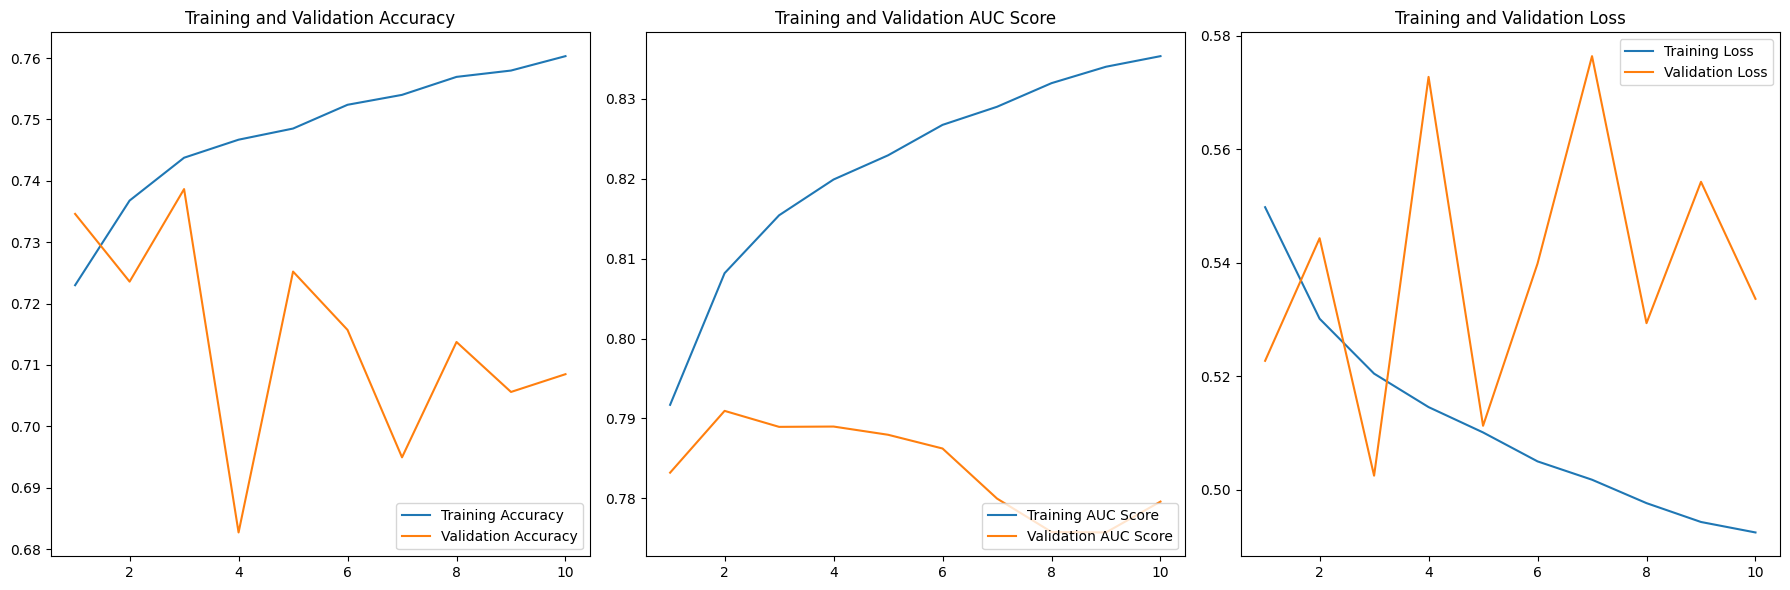

In [29]:
# Extract the relevant metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
auc = history.history['auc']
val_auc = history.history['val_auc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, epochs + 1)

# Create subplots
plt.figure(figsize=(18, 6))

# Plot Training and Validation Accuracy
plt.subplot(1, 3, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

# Plot Training and Validation AUC Score
plt.subplot(1, 3, 2)
plt.plot(epochs_range, auc, label='Training AUC Score')
plt.plot(epochs_range, val_auc, label='Validation AUC Score')
plt.legend(loc="lower right")
plt.title("Training and Validation AUC Score")

# Plot Training and Validation Loss
plt.subplot(1, 3, 3)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")

plt.tight_layout()
plt.show()

## The model is overfitting, lets add dropout layers

## Model 2

In [30]:
model = Sequential()
model.add(Dense(64, input_shape=(X_train.shape[-1],), activation="relu"))
model.add(Dense(32, activation="relu"))

## adding dropout layers which reduce overfitting
model.add(Dropout(0.4))
model.add(Dense(16, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(1, activation="sigmoid"))

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                704       
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3,329
Trainable params: 3,329
Non-traina

In [32]:
# Compile the model 
model.compile(optimizer=keras.optimizers.Adam(0.01),
             loss="binary_crossentropy",
             metrics=metrics)

In [33]:
epochs = 10
batch_size = 128
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size)

Epoch 1/10
1046/1046 [==============================] - 8s 6ms/step - loss: 0.5742 - accuracy: 0.7093 - auc: 0.7749 - val_loss: 0.5585 - val_accuracy: 0.7277 - val_auc: 0.7801
Epoch 2/10
1046/1046 [==============================] - 5s 5ms/step - loss: 0.5562 - accuracy: 0.7252 - auc: 0.7887 - val_loss: 0.5299 - val_accuracy: 0.7683 - val_auc: 0.7870
Epoch 3/10
1046/1046 [==============================] - 5s 5ms/step - loss: 0.5450 - accuracy: 0.7332 - auc: 0.7985 - val_loss: 0.4565 - val_accuracy: 0.7791 - val_auc: 0.7890
Epoch 4/10
1046/1046 [==============================] - 5s 5ms/step - loss: 0.5393 - accuracy: 0.7371 - auc: 0.8023 - val_loss: 0.5337 - val_accuracy: 0.7530 - val_auc: 0.7916
Epoch 5/10
1046/1046 [==============================] - 5s 5ms/step - loss: 0.5363 - accuracy: 0.7385 - auc: 0.8045 - val_loss: 0.5833 - val_accuracy: 0.7195 - val_auc: 0.7901
Epoch 6/10
1046/1046 [==============================] - 5s 5ms/step - loss: 0.5339 - accuracy: 0.7420 - auc: 0.8072 - va

In [34]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc'])

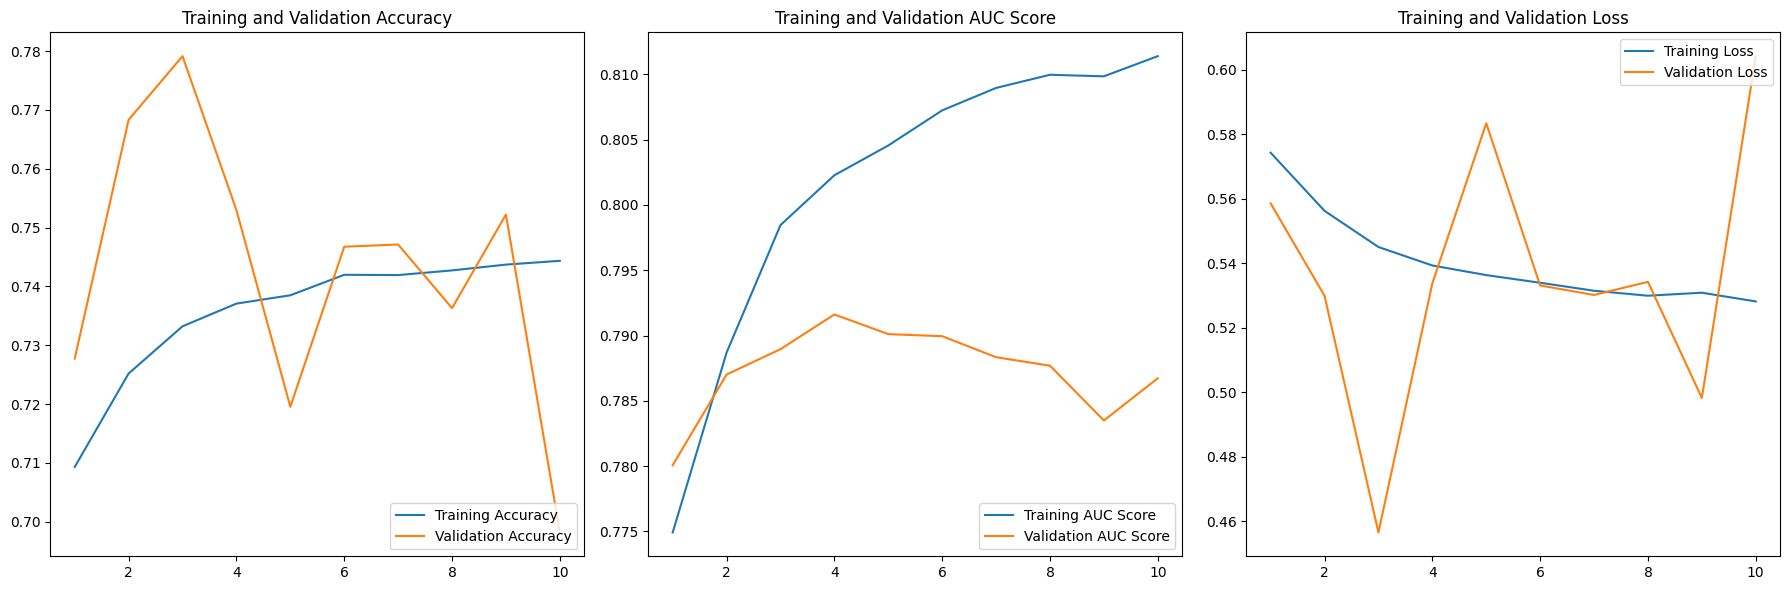

In [35]:
# Extract the relevant metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
auc = history.history['auc']
val_auc = history.history['val_auc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, epochs + 1)

# Create subplots
plt.figure(figsize=(18, 6))

# Plot Training and Validation Accuracy
plt.subplot(1, 3, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

# Plot Training and Validation AUC Score
plt.subplot(1, 3, 2)
plt.plot(epochs_range, auc, label='Training AUC Score')
plt.plot(epochs_range, val_auc, label='Validation AUC Score')
plt.legend(loc="lower right")
plt.title("Training and Validation AUC Score")

# Plot Training and Validation Loss
plt.subplot(1, 3, 3)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")

plt.tight_layout()
plt.show()


## Using Keras Tuner

In [36]:
import kerastuner as kt

In [37]:
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=[10]))
  
  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(keras.layers.Dense(1, activation='sigmoid'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  metrics = [
    keras.metrics.BinaryAccuracy("accuracy"),
    keras.metrics.AUC(curve="roc")]

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.BinaryCrossentropy(),
                metrics=metrics)

  return model

In [38]:
tuner = kt.RandomSearch(
    model_builder,
    objective='val_loss',
    max_trials=5)

In [39]:
# using early stopping to stop training the model when optimal value of recall and loss values are achieved.
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=5)

In [40]:
tuner.search(X_train, y_train, epochs=20, validation_data = (X_test, y_test), callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 5 Complete [00h 03m 31s]
val_loss: 0.4831046462059021

Best val_loss So Far: 0.45024433732032776
Total elapsed time: 00h 15m 53s

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 448 and the optimal learning rate for the optimizer
is 0.01.



In [41]:
model = Sequential()
model.add(Dense(384, input_shape=(X_train.shape[-1],), activation='relu'))
model.add(Dense(384, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [42]:
model.compile(optimizer=keras.optimizers.Adam(0.0001),
             loss='binary_crossentropy',
             metrics=metrics)

## Train the final model

In [43]:
epochs = 400 
batch_size = 128 
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size)

Epoch 1/400
1046/1046 [==============================] - 7s 5ms/step - loss: 0.5618 - accuracy: 0.7114 - auc: 0.7764 - val_loss: 0.5065 - val_accuracy: 0.7537 - val_auc: 0.7823
Epoch 2/400
1046/1046 [==============================] - 5s 5ms/step - loss: 0.5419 - accuracy: 0.7294 - auc: 0.7991 - val_loss: 0.5283 - val_accuracy: 0.7299 - val_auc: 0.7841
Epoch 3/400
1046/1046 [==============================] - 5s 5ms/step - loss: 0.5363 - accuracy: 0.7340 - auc: 0.8037 - val_loss: 0.4965 - val_accuracy: 0.7523 - val_auc: 0.7876
Epoch 4/400
1046/1046 [==============================] - 5s 5ms/step - loss: 0.5322 - accuracy: 0.7368 - auc: 0.8071 - val_loss: 0.5734 - val_accuracy: 0.6989 - val_auc: 0.7875
Epoch 5/400
1046/1046 [==============================] - 5s 5ms/step - loss: 0.5285 - accuracy: 0.7391 - auc: 0.8101 - val_loss: 0.5600 - val_accuracy: 0.7103 - val_auc: 0.7863
Epoch 6/400
1046/1046 [==============================] - 5s 5ms/step - loss: 0.5251 - accuracy: 0.7408 - auc: 0.812

## Saving the Model

In [44]:
model.save('patient_model.h5')